In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

In [2]:
consump_df = pd.read_csv('../data/CS/Hubballi_Dhaward_Water_Consumption_Nightlight_Population.csv')

feature_df = pd.read_csv('../outputs/segmentation_result_cleaned.csv')
print("Number of HHs with availabel SVI:", feature_df.shape[0])

building_df = pd.read_csv('../data/CS/Hubballi_CS_building.csv') 

# Drop rows with missing building height
building_df = building_df.dropna(subset=['building_height'])

cs_building_df = pd.merge(consump_df, building_df, on='sl_no', how='left')
print("Number of HHs with in Customer Survey:", cs_building_df.shape[0])

df = pd.merge(feature_df, cs_building_df, on='sl_no', how='left')
print("Number of HHs with both CS and SVI:", df.shape[0])

Number of HHs with availabel SVI: 28114
Number of HHs with in Customer Survey: 35980
Number of HHs with both CS and SVI: 28114


In [3]:
# Rename 'monthly_family_income' to 'Target'
df = df.rename(columns={'monthly_family_income': 'Target'})

# Drop rows with missing values in the 'Target' column
df = df.dropna(subset=['Target'])

# Reset the index after dropping rows
df = df.reset_index(drop=True)

# Create bins for water consumption levels and group the data
bins = [0, 8, 15, 25, float('inf')]
labels = ['0-8KL', '8-15KL', '15-25KL', '> 25KL']
df['consump_class'] = pd.cut(df['permonthunitskl'], bins=bins, labels=labels, right=False)

print(f"Shape of DataFrame after dropping rows with missing Target: {df.shape[0]}")

Shape of DataFrame after dropping rows with missing Target: 27128


In [4]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123, shuffle=True, stratify=df['Target'])
train_df.shape

(21702, 96)

In [5]:
train_df['Target'].value_counts()

Target
10-20K    11879
0-10K      5226
20-50K     4131
> 50K       466
Name: count, dtype: int64

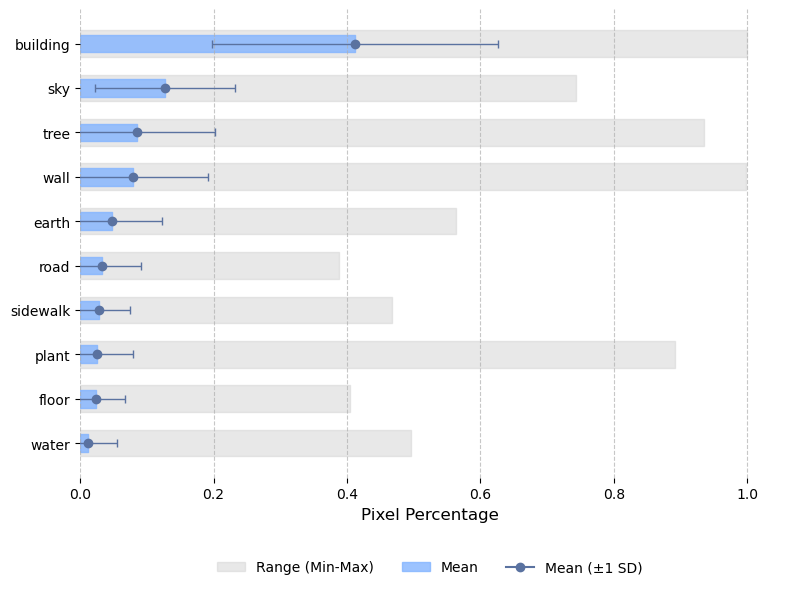

In [6]:
# Identify the top 10 objects by their overall mean percentage
object_columns = [col for col in feature_df.columns if col not in ['name', 'sl_no']]
top_10_objects = df[object_columns].mean().sort_values(ascending=False).head(10).index

# Calculate mean, min, max, and standard deviation for the top 10 objects
mean_values = train_df[top_10_objects].mean()
min_values = train_df[top_10_objects].min()
max_values = train_df[top_10_objects].max()
std_values = train_df[top_10_objects].std()  # Standard deviation

# Prepare data for plotting
categories = top_10_objects
y_positions = np.arange(len(categories))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Add light grey bars to show the range of values
for i, cat in enumerate(categories):
    ax.fill_betweenx(
        y=[i - 0.3, i + 0.3],
        x1=min_values[cat],
        x2=max_values[cat],
        color='lightgrey',
        alpha=0.5,
    )

# Add thicker inner bars for mean values with the new color and error bars
for i, cat in enumerate(categories):
    mean = mean_values[cat]
    std = std_values[cat]
    
    # Inner bar for the mean value
    ax.fill_betweenx(
        y=[i - 0.2, i + 0.2],  # Slightly thicker than before
        x1=0,
        x2=mean,
        color='#83B4FF',
        alpha=0.8,
    )
    
    # Error bar for ±1 standard deviation
    ax.errorbar(
        x=mean,
        y=i,
        xerr=std,
        fmt='o',
        color='#5A72A0', 
        capsize=3,
        capthick=1,
        elinewidth=1,
    )

# Customize the plot
ax.set_yticks(y_positions)
ax.set_yticklabels(categories, fontsize=10)
ax.set_xlabel('Pixel Percentage', fontsize=12)
ax.set_xlim(0, max(max_values) + 0.05)
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.invert_yaxis()  # Reverse the vertical axis for better readability

# Remove plot spines
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

# Create legend elements
range_patch = mpatches.Patch(color='lightgrey', alpha=0.5, label='Range (Min-Max)')
mean_patch = mpatches.Patch(color='#83B4FF', alpha=0.8, label='Mean')
error_line = mlines.Line2D([], [], color='#5A72A0', marker = 'o', linestyle='-', label='Mean (±1 SD)', markersize=6)

# Add legend
ax.legend(
    handles=[range_patch, mean_patch, error_line],
    fontsize=10,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False,
)

plt.tight_layout()
plt.show()


In [7]:
def create_categorical_group_plot(df, top_10_objects, group_col, group_labels, group_colors, xlabel, legend_title):
    """
    Create a dot plot for the top 10 objects grouped by a categorical column.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        top_10_objects (list): The top 10 objects to plot.
        group_col (str): The column to group by (e.g., 'water_storage_type').
        group_labels (list): The labels for the groups.
        group_colors (list): The colors for the groups.
        xlabel (str): Label for the x-axis.
        legend_title (str): Title for the legend.

    Returns:
        None
    """
    # Create a copy of the DataFrame and filter for the top 10 objects
    top_10_df = df[top_10_objects].copy()
    top_10_df[group_col] = df[group_col].values  # Add the group column without warnings

    # Calculate mean percentages and ranges for the top 10 objects grouped by the specified column
    mean_by_group = top_10_df.groupby(group_col, observed=True).mean()
    min_by_group = top_10_df.groupby(group_col, observed=True).min()
    max_by_group = top_10_df.groupby(group_col, observed=True).max()

    # Prepare data for plotting
    categories = mean_by_group.columns
    groups = mean_by_group.index
    data = mean_by_group.values.T  # Transpose for easy plotting
    min_data = min_by_group.values.T
    max_data = max_by_group.values.T

    # Create the dot plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Add dots for each group
    for i, (group, color) in enumerate(zip(groups, group_colors)):
        ax.scatter(data[:, i], np.arange(len(categories)), label=group, color=color, s=100)

    # Customize the plot
    ax.set_yticks(np.arange(len(categories)))
    ax.set_yticklabels(categories, fontsize=10)
    ax.set_xticks(np.arange(0, 0.55, 0.05))  # Adjust x-axis ticks as necessary
    ax.set_xlim(0, 0.55)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.invert_yaxis()  # To match the style of the reference image

    # Move the legend to the bottom in a single row
    ax.legend(
        title=legend_title,
        fontsize=10,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=len(groups),
        frameon=False,
    )

    # Remove plot spines
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()


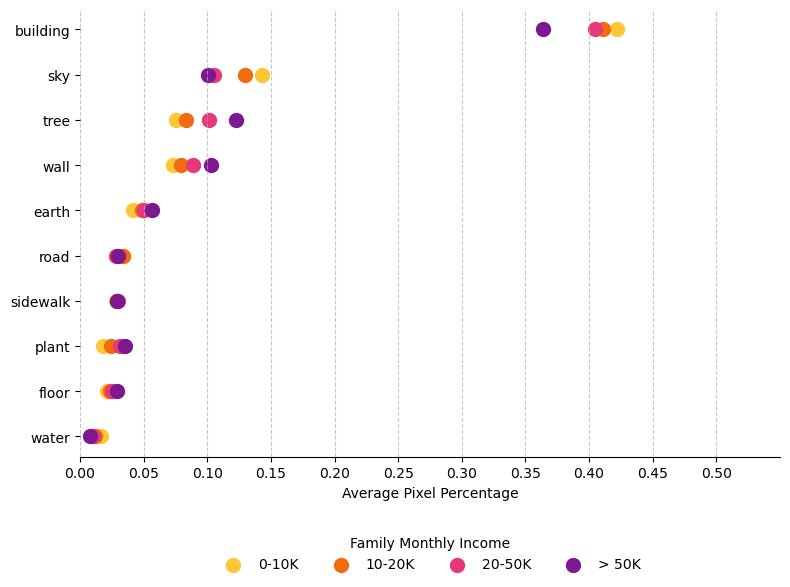

In [8]:
# Define parameters for family income group
group_col = 'Target'
group_labels = ['0-10K', '10-20K', '20-50K', '> 50 K']  # Update with actual labels
group_colors = ['#FCC737', '#F26B0F', '#E73879', '#7E1891'] # Example colors 
xlabel = 'Average Pixel Percentage'
legend_title = 'Family Monthly Income'

# Call the function
create_categorical_group_plot(
    train_df,
    top_10_objects,
    group_col,
    group_labels,
    group_colors,
    xlabel,
    legend_title
)


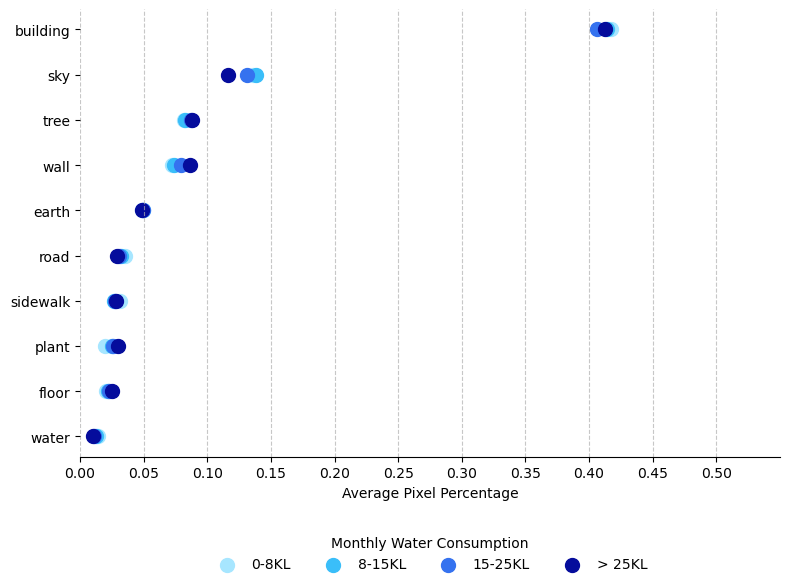

In [12]:
# Define parameters for water consumption
group_col = 'consump_class'
group_labels = ['0-8KL', '8-15KL', '15-25KL', '> 25KL']  # Update with actual labels
group_colors = ['#A7E6FF', '#3ABEF9', '#3572EF', '#050C9C']
xlabel = 'Average Pixel Percentage'
legend_title = 'Monthly Water Consumption'

# Call the function
create_categorical_group_plot(
    train_df,
    top_10_objects,
    group_col,
    group_labels,
    group_colors,
    xlabel,
    legend_title
)

C:\Users\doris\AppData\Local\Temp\ipykernel_8264\1446070948.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_df['Consumption_Class'] = train_df['consump_class']


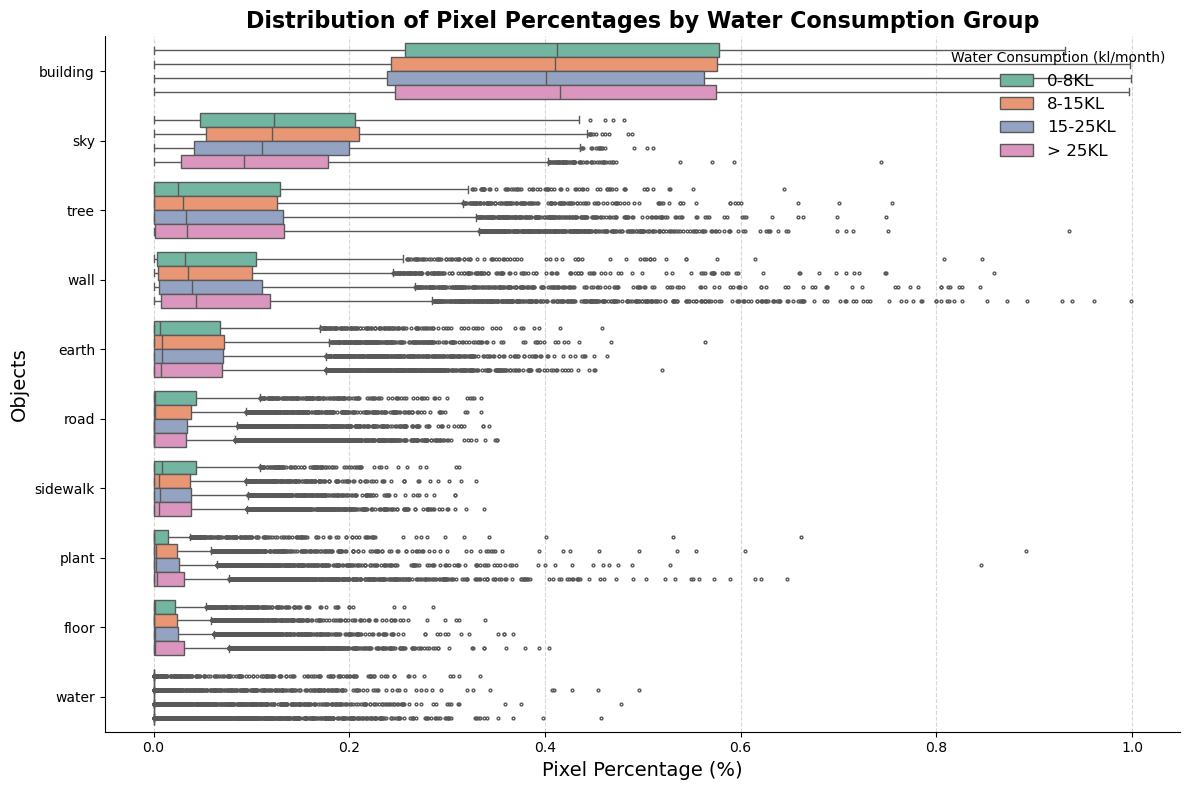

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create bins for water consumption levels and group the data
bins = [0, 8, 15, 25, float('inf')]
labels = ['0-8', '8-15', '15-25', '>25']
df['consump_class'] = pd.cut(df['permonthunitskl'], bins=bins, labels=labels, right=False)

# Filter the data to include only the top 10 objects
top_10_df = train_df[top_10_objects]
top_10_df['Consumption_Class'] = train_df['consump_class']

# Melt the DataFrame to long format for easier plotting
melted_df = pd.melt(
    top_10_df,
    id_vars=['Consumption_Class'],
    value_vars=top_10_objects,
    var_name='Object',
    value_name='Pixel_Percentage',
)

# Create the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=melted_df,
    x='Pixel_Percentage',
    y='Object',
    hue='Consumption_Class',
    palette='Set2',
    fliersize=2,
    linewidth=1
)

# Customize the plot
plt.title('Distribution of Pixel Percentages by Water Consumption Group', fontsize=16, weight='bold')
plt.xlabel('Pixel Percentage (%)', fontsize=14)
plt.ylabel('Objects', fontsize=14)
plt.legend(title='Water Consumption (kl/month)', fontsize=12, loc='upper right', frameon=False)
sns.despine()  # Removes the top and right spines for a cleaner look
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


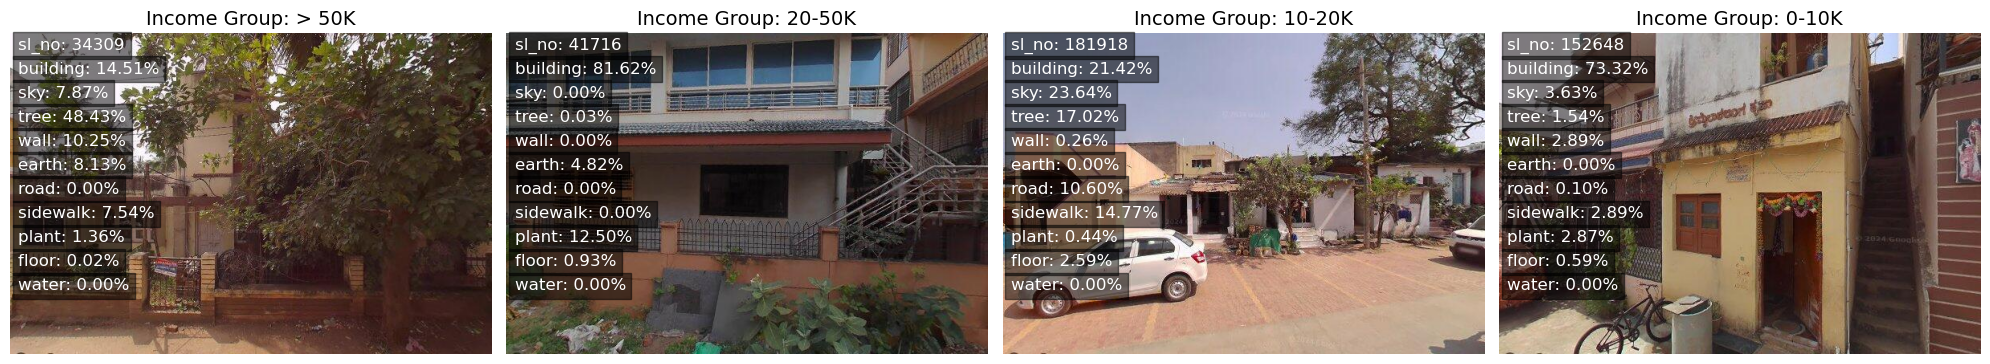

In [18]:
import random
import os
from PIL import Image

# Define the label mapping
label_mapping = {'0-10K': 0, '10-20K': 1, '20-50K': 2, '> 50K': 3}

# Define the relative path to the image folder
image_folder_path = "../data/raw/Hubballi_Original"
income_groups = train_df['Target'].unique()

# Sort income groups from richest to poorest
sorted_income_groups = sorted(income_groups, key=lambda x: int(label_mapping[x]), reverse=True)

# Identify the top 10 major objects
object_columns = [col for col in feature_df.columns if col not in ['name', 'sl_no']]
top_10_objects = df[object_columns].mean().sort_values(ascending=False).head(10).index

# Randomly select one image from each income group
selected_images = {}
for group in sorted_income_groups:
    group_df = train_df[train_df['Target'] == group]
    selected_image = group_df.sample(n=1).iloc[0]
    selected_images[group] = selected_image

# Plot the images and overlay the information
fig, axes = plt.subplots(1, len(sorted_income_groups), figsize=(20, 10))

for i, (group, image_row) in enumerate(selected_images.items()):
    image_name = image_row['name']
    image_path = os.path.join(image_folder_path, image_name)

    # Ensure the path is valid and standardized
    image_path = os.path.normpath(image_path)

    # Load the image
    try:
        image = Image.open(image_path)
    except Exception as e:
        print(f"Error loading image: {image_path}, Error: {e}")
        continue

    # Get the `sl_no` and pixel percentages for the top 10 objects
    sl_no = image_row['sl_no']
    top_3_values = [f"{obj}: {image_row[obj]:.2%}" for obj in top_10_objects]

    # Display the image
    ax = axes[i]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Income Group: {group}", fontsize=14)

    # Add `sl_no` and pixel percentage text on top of the image
    ax.text(10, 20, f"sl_no: {sl_no}", color='white', fontsize=12,
            bbox=dict(facecolor='black', alpha=0.5))
    for j, text in enumerate(top_3_values):
        ax.text(10, 50 + j * 30, text, color='white', fontsize=12,
                bbox=dict(facecolor='black', alpha=0.5))

# Adjust layout
plt.tight_layout()
plt.show()
